In [117]:
#### Preamble ####
# Purpose: Model the data to predict total income
# Author: Jiazhou(Justin) Bi and Weiyang Li
# Date: 4 October 2024
# Contact: justin.bi@mail.utoronto.ca or weiyang.li@mail.utoronto.ca
# License: MIT
# Pre-requisites: python 3.10.5 or above, with pandas, and sklearn installed for python
# Any other information needed? None

In [130]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
# Adding progress bar for the model's training
from sklearn.utils import parallel_backend
from tqdm import tqdm
import joblib

df = pd.read_parquet('../data/02-analysis_data/cleaned_data.parquet')
df.head()

,STATEICP,GQ,MORTGAGE,SEX,AGE,MARST,EDUC,SCHLTYPE,OCC2010,IND1990,INCTOT,VETSTAT,EDUC_new
0,41,1,3,2,51,6,10,1,800,850,120000,1,4
1,41,1,3,1,61,1,8,1,4810,711,200000,1,4
2,41,1,1,1,63,1,7,1,8030,50,40000,1,4
3,41,1,1,2,36,4,7,1,120,702,50000,1,4
4,41,1,1,1,17,6,5,3,4000,641,400,1,3


In [131]:
# Convert 'EDUC_new' and 'SEX' to numeric, coercing any invalid values to NaN
df['EDUC_new'] = pd.to_numeric(df['EDUC_new'], errors='coerce')
df['SEX'] = pd.to_numeric(df['SEX'], errors='coerce')

# Check if the conversion worked
print(df[['EDUC_new', 'SEX']].head())

# Create the interaction term between EDUC_new and SEX
df['EDUC_SEX_INTERACTION'] = df['EDUC_new'] * df['SEX']

# Display the first few rows to check the result
df.head()


   EDUC_new  SEX
0         4    2
1         4    1
2         4    1
3         4    2
4         3    1


,STATEICP,GQ,MORTGAGE,SEX,AGE,MARST,EDUC,SCHLTYPE,OCC2010,IND1990,INCTOT,VETSTAT,EDUC_new,EDUC_SEX_INTERACTION
0,41,1,3,2,51,6,10,1,800,850,120000,1,4,8
1,41,1,3,1,61,1,8,1,4810,711,200000,1,4,4
2,41,1,1,1,63,1,7,1,8030,50,40000,1,4,4
3,41,1,1,2,36,4,7,1,120,702,50000,1,4,8
4,41,1,1,1,17,6,5,3,4000,641,400,1,3,3


# Linear Regression

In [132]:
X = df.drop(columns=['INCTOT'])
y = df['INCTOT']
categorical_features = [
                        'STATEICP',
                        'GQ',
                        'MORTGAGE',
#                        'SEX',
                        'MARST',
#                        'EDUC_new',
                        'SCHLTYPE',
                        'OCC2010',
                        'IND1990',
                        'VETSTAT'
                        ]
numerical_features = [
                        'AGE',
                        'EDUC_SEX_INTERACTION'
                        ]
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(), categorical_features),
#        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numerical_features)
    ])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=210)

In [133]:
X_train = X_train.dropna()
y_train = y_train.dropna()

# Create the pipeline and fit the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit the model
model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')

# Mean Squared Error: 7445603202.908898
# Root Mean Squared Error: 86287.90878743614

Mean Squared Error: 7445603202.908898
Root Mean Squared Error: 86287.90878743614


### Check VIF

In [134]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Preprocess the training data
X_train_processed = model.named_steps['preprocessor'].transform(X_train)

# Get the feature names after preprocessing
feature_names = preprocessor.get_feature_names_out()

# Create a DataFrame from the preprocessed data
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names)

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = feature_names
vif_data['VIF'] = [variance_inflation_factor(X_train_df.values, i) for i in range(X_train_df.shape[1])]

print(vif_data)


                     Feature        VIF
0              cat__STATEICP   3.309149
1                    cat__GQ   1.002440
2              cat__MORTGAGE   2.788439
3                 cat__MARST   1.779866
4              cat__SCHLTYPE   1.243023
5               cat__OCC2010   3.423697
6               cat__IND1990   8.998054
7               cat__VETSTAT  13.979986
8                   num__AGE  10.928711
9  num__EDUC_SEX_INTERACTION   6.981437


### Remove high correlated variables

In [135]:
X = df.drop(columns=['INCTOT'])
y = df['INCTOT']
categorical_features = [
                        'STATEICP',
                        'GQ',
                        'MORTGAGE',
#                        'SEX',
                        'MARST',
#                        'EDUC_new',
                        'SCHLTYPE',
                        'OCC2010',
                        'IND1990',
#                        'VETSTAT'
                        ]
numerical_features = [
                        'AGE',
                        'EDUC_SEX_INTERACTION'
                        ]
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(), categorical_features),
#        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numerical_features)
    ])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=210)

### Refit the model: Final one

In [136]:
# Create the pipeline and fit the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

# Extract the coefficients
coefficients = model.named_steps['regressor'].coef_
feature_names = model.named_steps['preprocessor'].get_feature_names_out()
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)
print(coef_df)

MSE: 7448800507.007761
RMSE: 86306.43375211237
                     Feature   Coefficient
2              cat__MORTGAGE  11267.898316
7                   num__AGE    415.905987
0              cat__STATEICP    126.393407
6               cat__IND1990    -43.181001
5               cat__OCC2010   -139.546200
8  num__EDUC_SEX_INTERACTION  -1832.317721
3                 cat__MARST  -5541.387047
1                    cat__GQ  -7956.893797
4              cat__SCHLTYPE -16320.741370


### Re-check VIF

In [137]:
# Preprocess the training data
X_train_processed = model.named_steps['preprocessor'].transform(X_train)

# Get the feature names after preprocessing
feature_names = preprocessor.get_feature_names_out()

# Create a DataFrame from the preprocessed data
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names)

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = feature_names
vif_data['VIF'] = [variance_inflation_factor(X_train_df.values, i) for i in range(X_train_df.shape[1])]

print(vif_data)

                     Feature       VIF
0              cat__STATEICP  3.242254
1                    cat__GQ  1.002419
2              cat__MORTGAGE  2.658013
3                 cat__MARST  1.741158
4              cat__SCHLTYPE  1.239412
5               cat__OCC2010  3.187731
6               cat__IND1990  8.490997
7                   num__AGE  7.871046
8  num__EDUC_SEX_INTERACTION  6.945850


### Analyze Residual

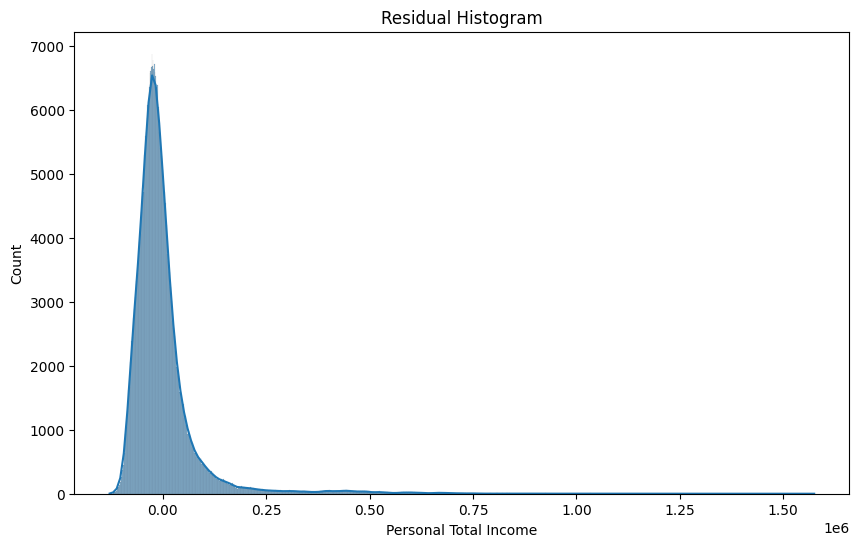

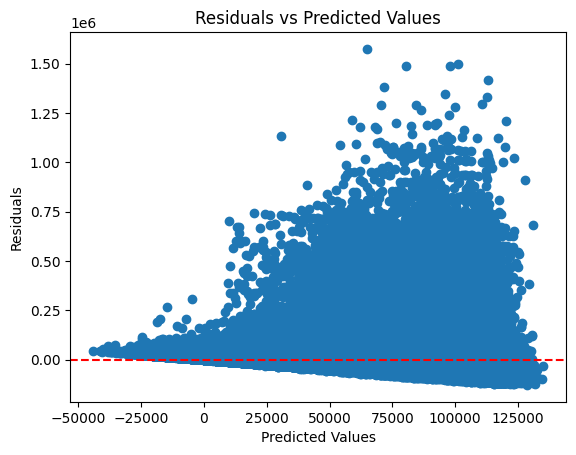

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns

# Residuals
residuals = y_test - y_pred

# Plot the residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Residual Histogram')
plt.xlabel('Personal Total Income')
plt.show()

# Scatter plot of residuals vs predicted values
plt.scatter(y_pred, residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()


### Compute R^2

In [139]:
from sklearn.metrics import r2_score

# Compute R-squared
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

# Adjusted R-squared
n = X_test.shape[0]  # Number of observations
p = X_test.shape[1]  # Number of predictors
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f'Adjusted R-squared: {adj_r2}')

# R-squared: 0.07749380179559828
# Adjusted R-squared: 0.07746372411168123

R-squared: 0.07749380179559828
Adjusted R-squared: 0.07746587258271909


# Random Forest

In [140]:
X = df.drop(columns=['INCTOT'])
y = df['INCTOT']
categorical_features = [
#                        'STATEICP',
#                        'GQ',
                        'MORTGAGE',
                        'SEX',
                        'MARST',
                        'EDUC_new',
                        'SCHLTYPE',
#                        'OCC2010',
                        'IND1990',
                        'VETSTAT'
                        ]
numerical_features = [
                        'AGE',
#                        'EDUC_SEX_INTERACTION'
                        ]
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(), categorical_features),
#        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numerical_features)
    ])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=210)

In [141]:
# Create the pipeline and fit the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=210, max_depth=15))
])

# Fit the model
model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print(f'Mean Squared Error: {mse}')
print(f'Rooted Mean Squared Error: {rmse}')
# Mean Squared Error: 5960198248.72675
# Rooted Mean Squared Error: 77202.32022890731

Mean Squared Error: 5960198248.72675
Rooted Mean Squared Error: 77202.32022890731


### Hyperparameter Tuning

In [142]:
from sklearn.model_selection import GridSearchCV
import pandas as pd

# Define the fraction of the training data (10%)
sample_fraction = 0.1

# Subsample the training data
X_train_sampled = X_train.sample(frac=sample_fraction, random_state=154)
y_train_sampled = y_train.loc[X_train_sampled.index]

# Define parameter grid
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [10, 15, 20],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

# Perform Grid Search with subsampled training data
grid_search = GridSearchCV(model, param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train_sampled, y_train_sampled)

# Print best parameters
print("Best Parameters: ", grid_search.best_params_)

# Use the best model found
best_model = grid_search.best_estimator_

# Predict using the best model on the full test set
y_pred_best = best_model.predict(X_test)
mse_best = mean_squared_error(y_test, y_pred_best)
rmse_best = mse_best ** 0.5

print(f'Best Model MSE: {mse_best}')
print(f'Best Model RMSE: {rmse_best}')


# Best Parameters:  {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 300}
# Best Model MSE: 6057426411.648569
# Best Model RMSE: 77829.47007174448

Best Parameters:  {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 300}
Best Model MSE: 6057426411.648569
Best Model RMSE: 77829.47007174448


### Feature Importance

In [143]:
# Extract feature importances from the best model
feature_importances = best_model.named_steps['regressor'].feature_importances_
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Create a DataFrame to display the feature importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the DataFrame
print(importance_df)


         Feature  Importance
3  cat__EDUC_new    0.337065
5   cat__IND1990    0.243451
7       num__AGE    0.193932
1       cat__SEX    0.149342
2     cat__MARST    0.055948
0  cat__MORTGAGE    0.013061
4  cat__SCHLTYPE    0.004251
6   cat__VETSTAT    0.002948


### Analyze Residual

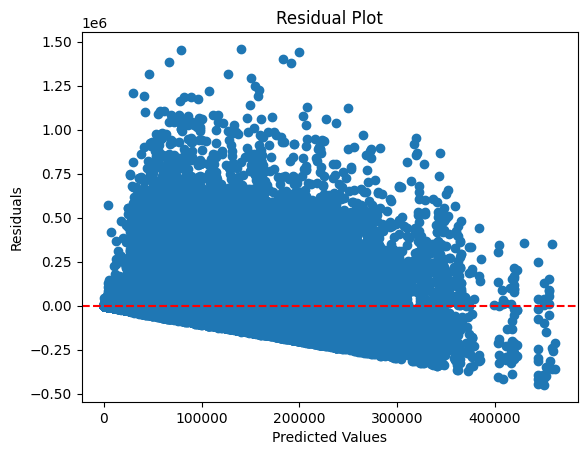

In [144]:
import matplotlib.pyplot as plt

# Calculate residuals
residuals = y_test - y_pred_best

# Plot the residuals
plt.scatter(y_pred_best, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# XGBoost

In [145]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

X = df.drop(columns=['INCTOT'])
y = df['INCTOT']

# Define the categorical and numerical features
categorical_features = [
#    'STATEICP',
#    'GQ',
    'MORTGAGE',
    'SEX',
    'MARST',
    'EDUC_new',
    'SCHLTYPE',
#    'OCC2010',
    'IND1990',
    'VETSTAT'
]
numerical_features = [
    'AGE'
]

# Preprocessor for handling categorical and numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(), categorical_features),
        ('num', 'passthrough', numerical_features)
    ])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=210)

# Create the XGBoost pipeline
xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=210))
])

# Fit the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model using MSE and RMSE
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = mse_xgb ** 0.5

print(f'XGBoost Mean Squared Error: {mse_xgb}')
print(f'XGBoost Root Mean Squared Error: {rmse_xgb}')

# XGBoost Mean Squared Error: 5899155116.290045
# XGBoost Root Mean Squared Error: 76805.95755727576

XGBoost Mean Squared Error: 5899155116.290045
XGBoost Root Mean Squared Error: 76805.95755727576


### Hyperparameter Tuning with GridSearchCV

In [146]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__max_depth': [4, 6, 8],
    'regressor__min_child_weight': [1, 3, 5]
}

grid_search = GridSearchCV(xgb_model, param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best Parameters: ", grid_search.best_params_)

# Best Parameters:  {'regressor__learning_rate': 0.1, 'regressor__max_depth': 6, 'regressor__min_child_weight': 5, 'regressor__n_estimators': 300}

Best Parameters:  {'regressor__learning_rate': 0.1, 'regressor__max_depth': 6, 'regressor__min_child_weight': 5, 'regressor__n_estimators': 300}


### Final model

In [150]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

# Create the pipeline with XGBoost
final_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        learning_rate=0.1, 
        max_depth=6, 
        min_child_weight=5, 
        n_estimators=300, 
        random_state=210
    ))
])

# Fit the final model on the full training set
final_model_pipeline.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred_final = final_model_pipeline.predict(X_test)

# Evaluate the final model using RMSE
mse_final = mean_squared_error(y_test, y_pred_final)
rmse_final = mse_final ** 0.5

print(f'Final XGBoost Model MSE: {mse_final}')
print(f'Final XGBoost Model RMSE: {rmse_final}')

# Final XGBoost Model MSE: 5854629848.133301
# Final XGBoost Model RMSE: 76515.55298194806

Final XGBoost Model MSE: 5854629848.133301
Final XGBoost Model RMSE: 76515.55298194806


### Residual Analysis

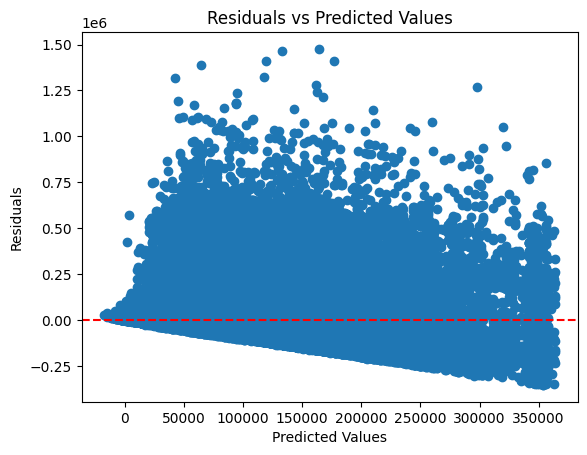

In [151]:
import matplotlib.pyplot as plt

# Calculate residuals
residuals = y_test - y_pred_final

# Plot residuals vs predicted values
plt.scatter(y_pred_final, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()


### CV

In [153]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Perform cross-validation with the pipeline model
cv_scores = cross_val_score(final_model_pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Calculate RMSE for each fold
cv_rmse_scores = np.sqrt(-cv_scores)

# Print each fold’s RMSE and the average RMSE
for i, score in enumerate(cv_rmse_scores, 1):
    print(f"Fold {i} RMSE: {score:.2f}")

print(f"\nAverage CV RMSE: {cv_rmse_scores.mean():.2f}")

Fold 1 RMSE: 76693.86
Fold 2 RMSE: 75692.41
Fold 3 RMSE: 76193.42
Fold 4 RMSE: 77365.82
Fold 5 RMSE: 76552.10

Average CV RMSE: 76499.52
